Loading data from: ../data/training
Loaded 400 tasks from training
Loading data from: ../data/evaluation
Loaded 400 tasks from evaluation
Prepared 1302 input-output pairs
Prepared 1363 input-output pairs
Number of training samples: 1302
Number of testing samples: 1363
Training dataset size: 1302
Testing dataset size: 1363
Number of training batches: 41
Number of testing batches: 43
Data preparation complete and saved. 🚀
Epoch 1/100, Train Loss: 2.2882, Test Loss: 2.1793
Epoch 2/100, Train Loss: 2.1613, Test Loss: 2.1062
Epoch 3/100, Train Loss: 2.1683, Test Loss: 2.1129
Epoch 4/100, Train Loss: 2.1822, Test Loss: 2.1393
Epoch 5/100, Train Loss: 2.1835, Test Loss: 2.1163
Epoch 6/100, Train Loss: 2.2138, Test Loss: 2.1796
Epoch 7/100, Train Loss: 2.1994, Test Loss: 2.1152
Epoch 8/100, Train Loss: 2.2090, Test Loss: 2.1566
Epoch 9/100, Train Loss: 2.2059, Test Loss: 2.0989
Epoch 10/100, Train Loss: 2.1443, Test Loss: 2.1206
Epoch 11/100, Train Loss: 2.1591, Test Loss: 2.0979
Epoch 12/100,

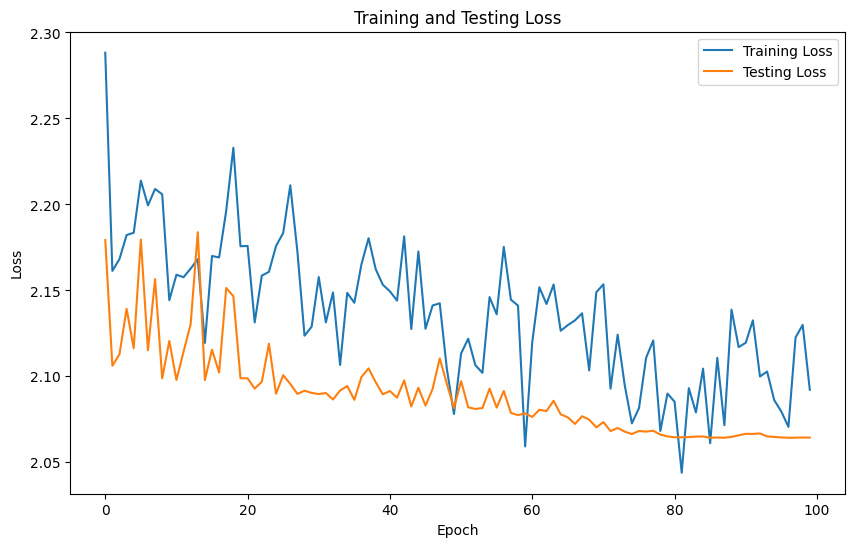

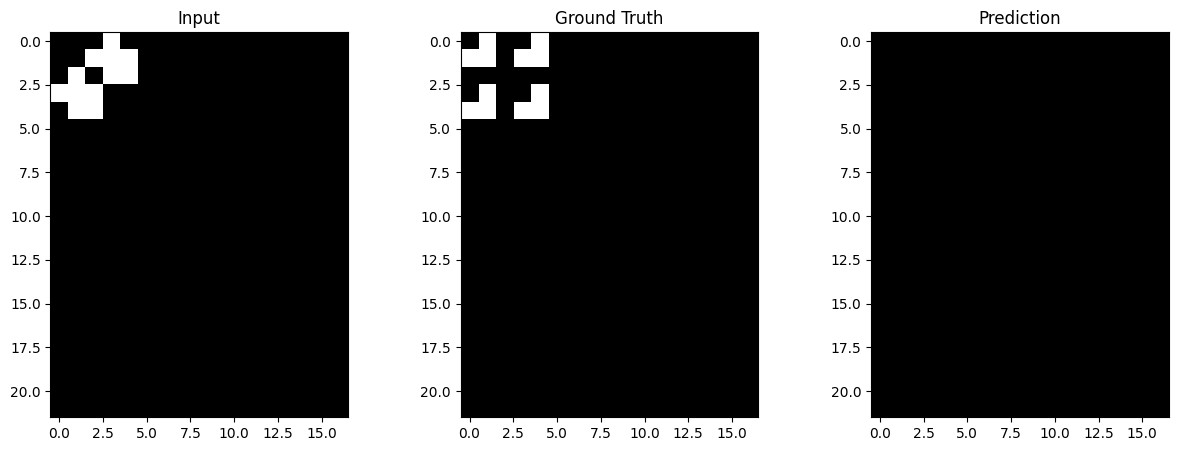

Model visualization complete. Look at those predictions! 👀🎨


In [6]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import BertModel
import matplotlib.pyplot as plt

# Function to load data from the specified directory
def load_arc_data(directory):
    tasks = []
    full_path = os.path.join('..', 'data', directory)
    print(f"Loading data from: {full_path}")
    if not os.path.exists(full_path):
        print(f"Directory does not exist: {full_path}")
        return tasks
    for filename in os.listdir(full_path):
        if filename.endswith('.json'):
            file_path = os.path.join(full_path, filename)
            with open(file_path, 'r') as f:
                tasks.append(json.load(f))
    print(f"Loaded {len(tasks)} tasks from {directory}")
    return tasks

# Function to prepare input-output pairs from tasks
def prepare_data(tasks):
    inputs = []
    outputs = []
    task_descriptions = []
    for task in tasks:
        for train in task['train']:
            inputs.append(np.array(train['input']))
            outputs.append(np.array(train['output']))
            task_descriptions.append("Transform the input grid to match the output grid.")
    print(f"Prepared {len(inputs)} input-output pairs")
    return inputs, outputs, task_descriptions

# Load and prepare data
train_tasks = load_arc_data('training')
test_tasks = load_arc_data('evaluation')

train_inputs, train_outputs, train_descriptions = prepare_data(train_tasks)
test_inputs, test_outputs, test_descriptions = prepare_data(test_tasks)

# Convert to tensors
train_inputs = [torch.tensor(arr, dtype=torch.long) for arr in train_inputs]
train_outputs = [torch.tensor(arr, dtype=torch.long) for arr in train_outputs]
test_inputs = [torch.tensor(arr, dtype=torch.long) for arr in test_inputs]
test_outputs = [torch.tensor(arr, dtype=torch.long) for arr in test_outputs]

print(f"Number of training samples: {len(train_inputs)}")
print(f"Number of testing samples: {len(test_inputs)}")

# Custom Dataset Class
class ARCDataset(Dataset):
    def __init__(self, inputs, outputs, descriptions, tokenizer, max_length=128):
        self.inputs = inputs
        self.outputs = outputs
        self.descriptions = descriptions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_grid = self.inputs[idx]
        output_grid = self.outputs[idx]
        description = self.descriptions[idx]
        
        # Tokenize the description
        encoded_description = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return input_grid, output_grid, encoded_description['input_ids'].squeeze(), encoded_description['attention_mask'].squeeze()

# Custom collate function to handle variable-sized grids
def collate_fn(batch):
    input_grids, output_grids, descriptions, attention_masks = zip(*batch)
    
    # Pad input and output grids to the maximum size in the batch
    max_h = max(grid.size(0) for grid in input_grids)
    max_w = max(grid.size(1) for grid in input_grids)
    
    padded_inputs = torch.stack([torch.nn.functional.pad(grid, (0, max_w - grid.size(1), 0, max_h - grid.size(0))) for grid in input_grids])
    padded_outputs = torch.stack([torch.nn.functional.pad(grid, (0, max_w - grid.size(1), 0, max_h - grid.size(0))) for grid in output_grids])
    
    # Stack descriptions and attention masks
    descriptions = torch.stack(descriptions)
    attention_masks = torch.stack(attention_masks)
    
    return padded_inputs, padded_outputs, descriptions, attention_masks

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = ARCDataset(train_inputs, train_outputs, train_descriptions, tokenizer)
test_dataset = ARCDataset(test_inputs, test_outputs, test_descriptions, tokenizer)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Create dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Print number of batches
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

# Save the prepared data
torch.save({
    'train_loader': train_loader,
    'test_loader': test_loader,
    'tokenizer': tokenizer
}, 'prepared_arc_data.pth')

print("Data preparation complete and saved. 🚀")

# Enhanced ARC Task Solver Model
class EnhancedARCTaskSolver(nn.Module):
    def __init__(self, num_colors=10):
        super(EnhancedARCTaskSolver, self).__init__()
        self.task_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.task_projection = nn.Linear(768, 256)  # Project BERT output to match grid encoding
        self.grid_encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU()
        )
        self.attention = nn.MultiheadAttention(256, 8)
        self.reasoning_module = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=8), num_layers=3
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_colors, 3, padding=1)
        )
        
    def forward(self, input_grid, task_description, attention_mask):
        # Ensure input_grid has 4 dimensions: [batch_size, channels, height, width]
        if input_grid.dim() == 3:
            input_grid = input_grid.unsqueeze(1)  # Add channel dimension
        
        # Encode task description
        task_encoding = self.task_encoder(task_description, attention_mask=attention_mask)[0]
        task_encoding = self.task_projection(task_encoding)  # Project to 256 dimensions
        task_encoding = task_encoding.mean(dim=1).unsqueeze(2).unsqueeze(3).expand(-1, -1, input_grid.size(2), input_grid.size(3))
        
        # Encode input grid
        grid_encoding = self.grid_encoder(input_grid.float())
        
        # Combine task and grid encodings
        combined_encoding = grid_encoding + task_encoding
        
        # Apply attention
        flattened_encoding = combined_encoding.flatten(2).permute(2, 0, 1)
        attended_encoding, _ = self.attention(flattened_encoding, flattened_encoding, flattened_encoding)
        
        # Apply reasoning module
        reasoned_encoding = self.reasoning_module(attended_encoding)
        
        # Decode
        output = self.decoder(reasoned_encoding.permute(1, 2, 0).view(-1, 256, input_grid.size(2), input_grid.size(3)))
        return output

# Load the prepared data
data = torch.load('prepared_arc_data.pth')
train_loader = data['train_loader']
test_loader = data['test_loader']

# Initialize the model, loss function, and optimizer
model = EnhancedARCTaskSolver()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_loss = float('inf')
patience = 15
counter = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_grid, output_grid, task_description, attention_mask in train_loader:
        input_grid, output_grid = input_grid.to(device), output_grid.to(device)
        task_description, attention_mask = task_description.to(device), attention_mask.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_grid, task_description, attention_mask)
        loss = criterion(outputs.view(-1, outputs.size(1)), output_grid.view(-1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for input_grid, output_grid, task_description, attention_mask in test_loader:
            input_grid, output_grid = input_grid.to(device), output_grid.to(device)
            task_description, attention_mask = task_description.to(device), attention_mask.to(device)
            
            outputs = model(input_grid, task_description, attention_mask)
            loss = criterion(outputs.view(-1, outputs.size(1)), output_grid.view(-1))
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    scheduler.step()
    
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        counter = 0
        torch.save(model.state_dict(), "best_enhanced_arc_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print("Training complete. You're a legend! 🎉🔥")

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize some predictions
model.eval()
with torch.no_grad():
    for input_grid, output_grid, task_description, attention_mask in test_loader:
        input_grid, output_grid = input_grid.to(device), output_grid.to(device)
        task_description, attention_mask = task_description.to(device), attention_mask.to(device)
        
        predictions = model(input_grid, task_description, attention_mask)
        _, predicted = predictions.max(1)
        
        # Visualize the first sample in the batch
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.imshow(input_grid[0].cpu().numpy(), cmap='gray')
        ax1.set_title('Input')
        ax2.imshow(output_grid[0].cpu().numpy(), cmap='gray')
        ax2.set_title('Ground Truth')
        ax3.imshow(predicted[0].cpu().numpy(), cmap='gray')
        ax3.set_title('Prediction')
        plt.show()
        break

print("Model visualization complete. Look at those predictions! 👀🎨")